In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, GRU, Bidirectional
from keras.optimizers import SGD

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import math
import warnings
warnings.filterwarnings("ignore")

Model **using MSFT dataset(1 day interval)** **bold text**

---



In [2]:
df = pd.read_csv("MSFT.csv", index_col='Date', parse_dates=["Date"])
df.shape

(8857, 6)

In [3]:
df.tail(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-04-27,261.579987,263.190002,260.119995,261.970001,261.970001,31014200
2021-04-28,256.079987,256.540009,252.949997,254.559998,254.559998,46903100
2021-04-29,255.460007,256.100006,249.000000,252.509995,252.509995,40589000
2021-04-30,249.740005,253.080002,249.600006,252.179993,252.179993,30929200
2021-05-03,253.399994,254.350006,251.119995,251.860001,251.860001,19598900


In [4]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1986-03-13,0.088542,0.101563,0.088542,0.097222,0.061751,1031788800
1986-03-14,0.097222,0.102431,0.097222,0.100694,0.063956,308160000
1986-03-17,0.100694,0.103299,0.100694,0.102431,0.065059,133171200
1986-03-18,0.102431,0.103299,0.098958,0.099826,0.063405,67766400
1986-03-19,0.099826,0.100694,0.097222,0.098090,0.062302,47894400
...,...,...,...,...,...,...
2021-04-27,261.579987,263.190002,260.119995,261.970001,261.970001,31014200
2021-04-28,256.079987,256.540009,252.949997,254.559998,254.559998,46903100
2021-04-29,255.460007,256.100006,249.000000,252.509995,252.509995,40589000


In [5]:
df1=df['Close']
df1.shape

(8857,)

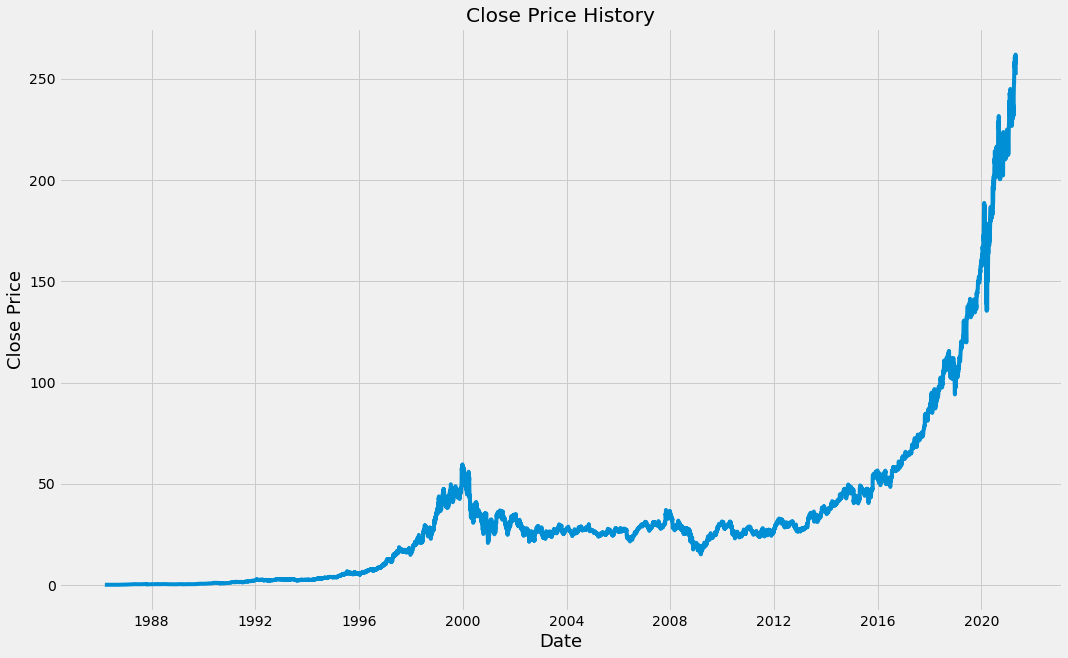

In [6]:
plt.figure(figsize=(16,10))
plt.title("Close Price History")
plt.plot(df1)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price',fontsize=18)
plt.show()

In [7]:
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [8]:
df1.shape

(8857, 1)

In [9]:
#splitting dataset
training_size=int(len(df1)*0.75)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]
training_size,test_size

(6642, 2215)

In [10]:
df1

array([[2.65159923e-05],
       [3.97739884e-05],
       [4.64067989e-05],
       ...,
       [9.63876521e-01],
       [9.62616393e-01],
       [9.61394489e-01]])

In [11]:
def create_dataset(dataset, time_step=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-time_step-1):
    a = dataset[i:(i+time_step), 0]
    dataX.append(a)
    dataY.append(dataset[i + time_step, 0])
  return numpy.array(dataX), numpy.array(dataY)

In [12]:
import numpy
time_step = 100
x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

In [13]:
print(x_train)

[[2.65159923e-05 3.97739884e-05 4.64067989e-05 ... 3.31449904e-05
  2.98304913e-05 2.98304913e-05]
 [3.97739884e-05 4.64067989e-05 3.64594894e-05 ... 2.98304913e-05
  2.98304913e-05 2.65159923e-05]
 [4.64067989e-05 3.64594894e-05 2.98304913e-05 ... 2.98304913e-05
  2.65159923e-05 2.32014933e-05]
 ...
 [1.15166312e-01 1.14402600e-01 1.19137605e-01 ... 1.17113772e-01
  1.16884661e-01 1.14937202e-01]
 [1.14402600e-01 1.19137605e-01 1.18984859e-01 ... 1.16884661e-01
  1.14937202e-01 1.14211676e-01]
 [1.19137605e-01 1.18984859e-01 1.19710385e-01 ... 1.14937202e-01
  1.14211676e-01 1.13218853e-01]]


In [14]:
print(x_train.shape), print(y_train.shape)

(6541, 100)
(6541,)


(None, None)

In [15]:
print(x_test.shape), print(y_test.shape)

(2114, 100)
(2114,)


(None, None)

In [16]:
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1], 1)

In [17]:
# The GRU architecture
model = Sequential()
# First GRU layer with Dropout regularisation
model.add(GRU(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))
# Second GRU layer
model.add(GRU(units=50, return_sequences=True))
model.add(Dropout(0.2))
# Third GRU layer
model.add(GRU(units=50, return_sequences=True))
model.add(Dropout(0.2))
# Fourth GRU layer
model.add(GRU(units=50))
model.add(Dropout(0.2))
# The output layer
model.add(Dense(units=1))

# Compiling the RNN
model.compile(optimizer='adam',loss='mean_squared_error')
# Fitting to the training set
model.fit(x_train,y_train,epochs=10,batch_size=32)

Epoch 1/10
205/205 [==============================] - 87s 327ms/step - loss: 9.1308e-04
Epoch 2/10
205/205 [==============================] - 61s 295ms/step - loss: 8.8173e-05
Epoch 3/10
205/205 [==============================] - 71s 347ms/step - loss: 7.0370e-05
Epoch 4/10
205/205 [==============================] - 67s 325ms/step - loss: 6.7277e-05
Epoch 5/10
205/205 [==============================] - 74s 363ms/step - loss: 6.2755e-05
Epoch 6/10
205/205 [==============================] - 77s 374ms/step - loss: 5.7604e-05
Epoch 7/10
205/205 [==============================] - 74s 362ms/step - loss: 5.4031e-05
Epoch 8/10
205/205 [==============================] - 75s 366ms/step - loss: 6.4450e-05
Epoch 9/10
205/205 [==============================] - 75s 368ms/step - loss: 4.5434e-05
Epoch 10/10
205/205 [==============================] - 77s 378ms/step - loss: 4.4441e-05


In [18]:
model.save("model.h5")

In [19]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 100, 50)           7950      
_________________________________________________________________
dropout (Dropout)            (None, 100, 50)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 100, 50)           15300     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 50)           0         
_________________________________________________________________
gru_2 (GRU)                  (None, 100, 50)           15300     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100, 50)           0         
_________________________________________________________________
gru_3 (GRU)                  (None, 50)                1

In [21]:
train_predict=model.predict(x_train)
test_predict=model.predict(x_test)

In [22]:
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [23]:
math.sqrt(mean_squared_error(y_train,train_predict))

21.89071012309709

In [24]:
math.sqrt(mean_squared_error(y_test,test_predict))

97.65123360056636

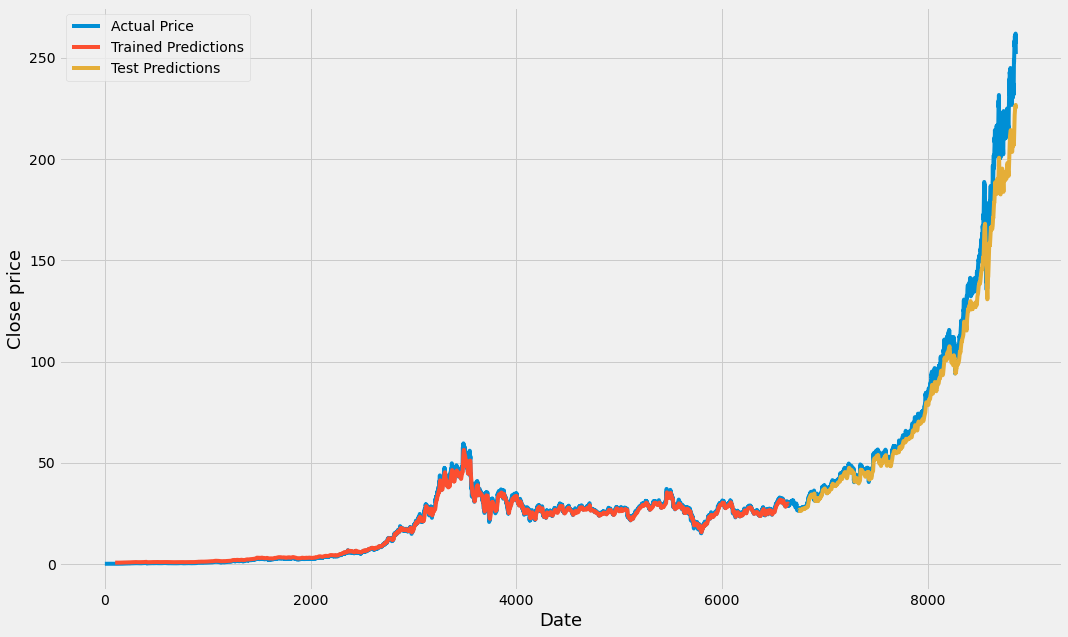

In [25]:
plt.figure(figsize=(16,10))
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict

plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close price',fontsize=18)
plt.legend(['Actual Price','Trained Predictions', 'Test Predictions'], loc='upper left')
plt.show()

In [27]:
len(test_data)
test_data

array([[0.11188236],
       [0.11207329],
       [0.11291337],
       ...,
       [0.96387652],
       [0.96261639],
       [0.96139449]])

In [28]:
x_input = test_data[2115:].reshape(1,-1)
x_input.shape

(1, 100)

In [29]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()
temp_input

[0.8244995597651891,
 0.8084235100302337,
 0.8035357746853464,
 0.8139985558456202,
 0.8175879992352969,
 0.8173207312522366,
 0.8369862243768686,
 0.8375208186093906,
 0.8343514177071526,
 0.8496256052265255,
 0.8547806668208744,
 0.8436305169237003,
 0.8502365867112368,
 0.858675600952907,
 0.8555825290364568,
 0.8461507135819318,
 0.8489764592489204,
 0.8309147488218542,
 0.8317166110374367,
 0.810141844472883,
 0.8332058419899194,
 0.838284516332079,
 0.830151051099166,
 0.8203755221429901,
 0.8257596872275054,
 0.8130821418849544,
 0.8116692399182598,
 0.8261415652220503,
 0.8563080622662512,
 0.8587137654458009,
 0.8624559250734548,
 0.8761263298952617,
 0.886818272812103,
 0.8889948142350851,
 0.9120206472592275,
 0.8854054291118095,
 0.9147700056740269,
 0.9142354114415049,
 0.9275621610280621,
 0.923781778641113,
 0.9245073118709073,
 0.9255383358430573,
 0.9305024584401337,
 0.926874850557563,
 0.9332518168549331,
 0.9351610902948547,
 0.9302351321906721,
 0.9321444056305938,

In [30]:
#predictions for next 10 days
from numpy import array
lst_output=[]
n_steps=100
i=0
while(i<10):
  if(len(temp_input)>100):
    x_input=np.array(temp_input[1:])
    print("{} day input {}".format(i,x_input))
    x_input=x_input.reshape(1,-1)
    x_input=x_input.reshape((1,n_steps,1))
    yhat = model.predict(x_input,verbose=0)
    print("{} day output {}".format(i,yhat))
    temp_input.extend(yhat[0].tolist())
    temp_input=temp_input[1:]
    lst_output.extend(yhat.tolist())
    i=i+1
  else:
    x_input = x_input.reshape((1,n_steps,1))
    yhat = model.predict(x_input,verbose=0)
    print(yhat[0])
    temp_input.extend(yhat[0].tolist())
    print(len(temp_input))
    lst_output.extend(yhat.tolist())
    i=i+1

print(lst_output)

[0.8488391]
101
1 day input [0.80842351 0.80353577 0.81399856 0.817588   0.81732073 0.83698622
 0.83752082 0.83435142 0.84962561 0.85478067 0.84363052 0.85023659
 0.8586756  0.85558253 0.84615071 0.84897646 0.83091475 0.83171661
 0.81014184 0.83320584 0.83828452 0.83015105 0.82037552 0.82575969
 0.81308214 0.81166924 0.82614157 0.85630806 0.85871377 0.86245593
 0.87612633 0.88681827 0.88899481 0.91202065 0.88540543 0.91477001
 0.91423541 0.92756216 0.92378178 0.92450731 0.92553834 0.93050246
 0.92687485 0.93325182 0.93516109 0.93023513 0.93214441 0.93057879
 0.91981052 0.89514268 0.89040772 0.89529545 0.87406434 0.88700921
 0.90442178 0.89269881 0.86860379 0.86543439 0.88403075 0.86795464
 0.89235515 0.88716193 0.90514731 0.8998777  0.89628825 0.90736207
 0.9048036  0.88067041 0.87925757 0.90079417 0.90686564 0.89877034
 0.88685644 0.90266522 0.89793026 0.88498539 0.89995408 0.92508013
 0.95074077 0.9461203  0.95391011 0.96670227 0.97663051 0.97685962
 0.98671141 0.97563765 0.99056818 

8 day output [[0.67430586]]
9 day input [0.84962561 0.85478067 0.84363052 0.85023659 0.8586756  0.85558253
 0.84615071 0.84897646 0.83091475 0.83171661 0.81014184 0.83320584
 0.83828452 0.83015105 0.82037552 0.82575969 0.81308214 0.81166924
 0.82614157 0.85630806 0.85871377 0.86245593 0.87612633 0.88681827
 0.88899481 0.91202065 0.88540543 0.91477001 0.91423541 0.92756216
 0.92378178 0.92450731 0.92553834 0.93050246 0.92687485 0.93325182
 0.93516109 0.93023513 0.93214441 0.93057879 0.91981052 0.89514268
 0.89040772 0.89529545 0.87406434 0.88700921 0.90442178 0.89269881
 0.86860379 0.86543439 0.88403075 0.86795464 0.89235515 0.88716193
 0.90514731 0.8998777  0.89628825 0.90736207 0.9048036  0.88067041
 0.87925757 0.90079417 0.90686564 0.89877034 0.88685644 0.90266522
 0.89793026 0.88498539 0.89995408 0.92508013 0.95074077 0.9461203
 0.95391011 0.96670227 0.97663051 0.97685962 0.98671141 0.97563765
 0.99056818 0.99530315 0.98766605 0.98583322 0.99469216 0.98167102
 0.99686876 0.99839616 

In [32]:
day_new=np.arange(1,101)
day_pred=np.arange(101,111)

In [33]:
len(df1)

8857

In [34]:
df3=df1.tolist()
df3.extend(lst_output)

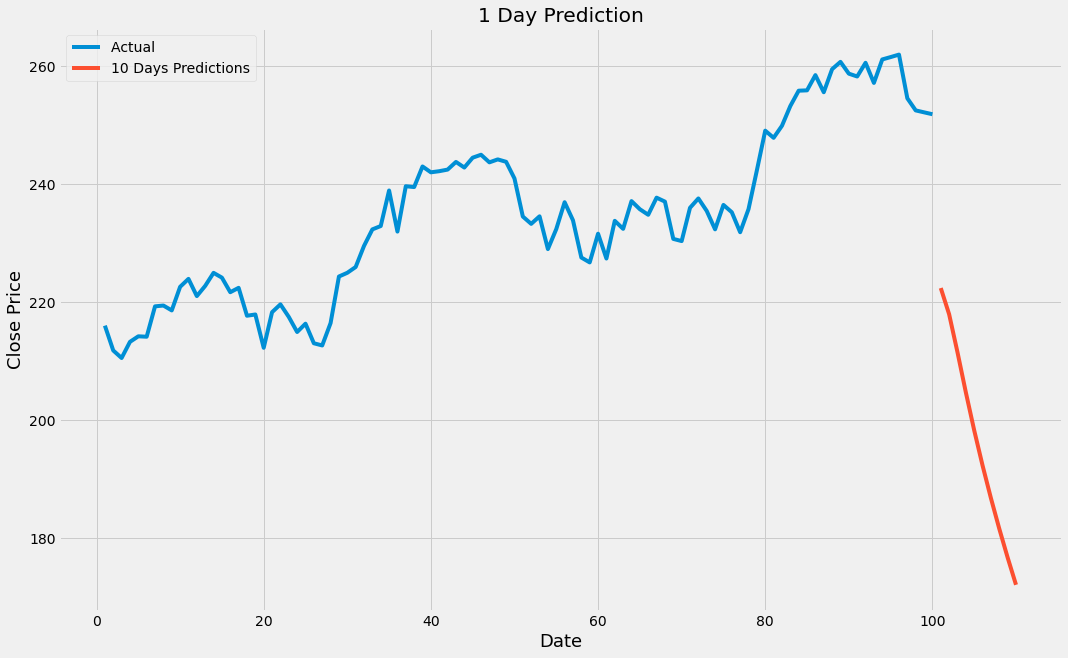

In [35]:
plt.figure(figsize=(16,10))
plt.plot(day_new,scaler.inverse_transform(df1[8757:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))
plt.title('1 Day Prediction')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price',fontsize=18)
plt.legend(['Actual ','10 Days Predictions'], loc='upper left')

In [36]:
lst_output

[[0.8488391041755676],
 [0.831843376159668],
 [0.8072276711463928],
 [0.7812687158584595],
 [0.7566734552383423],
 [0.7339102625846863],
 [0.712759256362915],
 [0.69295334815979],
 [0.6743058562278748],
 [0.6566882729530334]]

**Model using DataFrame dataset(1 Min Interval)**

In [38]:
df4 = pd.read_csv("DataFrame.csv", index_col='Date', parse_dates=["Date"])
df4.drop('Unnamed: 7' , axis = 1 , inplace = True)
df4.shape

(22805, 6)

In [39]:
df4

,Type,Time,open,high,low,close
Date,,,,,,
2021-01-01,NIFTY,09:16,13997.90,14020.85,13991.35,14013.15
2021-01-01,NIFTY,09:17,14014.85,14018.55,14008.15,14009.05
2021-01-01,NIFTY,09:18,14008.05,14013.10,14005.05,14012.70
2021-01-01,NIFTY,09:19,14013.65,14019.10,14013.65,14016.20
2021-01-01,NIFTY,09:20,14015.45,14017.80,14011.95,14015.45
...,...,...,...,...,...,...
2021-03-31,NIFTY,15:27,14687.35,14694.35,14686.30,14690.60
2021-03-31,NIFTY,15:28,14690.90,14690.90,14686.05,14689.30
2021-03-31,NIFTY,15:29,14690.30,14694.10,14688.55,14691.30


In [40]:
df5=df4['close']
df5.shape

(22805,)

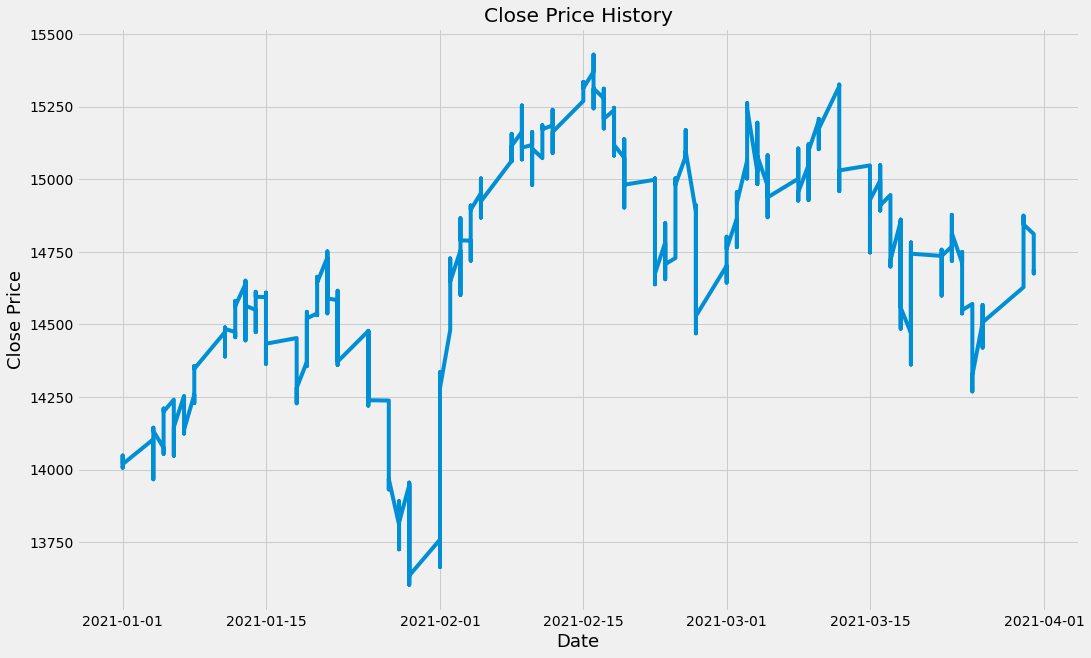

In [41]:
plt.figure(figsize=(16,10))
plt.title("Close Price History")
plt.plot(df5)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price',fontsize=18)
plt.show()

In [42]:
scaler=MinMaxScaler(feature_range=(0,1))
df5=scaler.fit_transform(np.array(df5).reshape(-1,1))

In [43]:
df5.shape

(22805, 1)

In [44]:
#splitting dataset
training_size=int(len(df5)*0.75)
test_size=len(df5)-training_size
train_data,test_data=df5[0:training_size,:],df5[training_size:len(df5),:1]
training_size,test_size

(17103, 5702)

In [45]:
df5

array([[0.22455401],
       [0.22231039],
       [0.22430776],
       ...,
       [0.59565503],
       [0.59661267],
       [0.59532669]])

In [46]:
def create_dataset(dataset, time_step=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-time_step-1):
    a = dataset[i:(i+time_step), 0]
    dataX.append(a)
    dataY.append(dataset[i + time_step, 0])
  return numpy.array(dataX), numpy.array(dataY)

In [47]:
import numpy
time_step = 100
x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

In [48]:
print(x_train)

[[0.22455401 0.22231039 0.22430776 ... 0.23465032 0.23470505 0.23399365]
 [0.22231039 0.22430776 0.22622305 ... 0.23470505 0.23399365 0.23470505]
 [0.22430776 0.22622305 0.22581263 ... 0.23399365 0.23470505 0.23407574]
 ...
 [0.76679982 0.76666302 0.76838678 ... 0.76726497 0.76387217 0.75850936]
 [0.76666302 0.76838678 0.76663566 ... 0.76387217 0.75850936 0.75637518]
 [0.76838678 0.76663566 0.76543176 ... 0.75850936 0.75637518 0.7538853 ]]


In [49]:
print(x_train.shape), print(y_train.shape)

(17002, 100)
(17002,)


(None, None)

In [50]:
print(x_test.shape), print(y_test.shape)

(5601, 100)
(5601,)


(None, None)

In [51]:
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1], 1)

In [52]:
model1=Sequential()
model1.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model1.add(LSTM(50,return_sequences=True))                               # MODEL PREPARED FOR LSTM
model1.add(LSTM(50))
model1.add(Dense(1))
model1.compile(loss='mean_squared_error',optimizer='adam')
model1.summary()          #Summary of Model Prepared

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [53]:
model1.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=10,batch_size=64,verbose=1)    # fitting Model

Epoch 1/10
266/266 [==============================] - 102s 330ms/step - loss: 0.0232 - val_loss: 2.3285e-04
Epoch 2/10
266/266 [==============================] - 91s 343ms/step - loss: 2.2202e-04 - val_loss: 2.2770e-04
Epoch 3/10
266/266 [==============================] - 88s 329ms/step - loss: 2.0686e-04 - val_loss: 2.6134e-04
Epoch 4/10
266/266 [==============================] - 93s 351ms/step - loss: 2.0482e-04 - val_loss: 1.8536e-04
Epoch 5/10
266/266 [==============================] - 88s 331ms/step - loss: 2.0031e-04 - val_loss: 1.7142e-04
Epoch 6/10
266/266 [==============================] - 91s 342ms/step - loss: 1.6271e-04 - val_loss: 3.0378e-04
Epoch 7/10
266/266 [==============================] - 85s 320ms/step - loss: 1.7034e-04 - val_loss: 1.4221e-04
Epoch 8/10
266/266 [==============================] - 90s 338ms/step - loss: 1.4898e-04 - val_loss: 1.3453e-04
Epoch 9/10
266/266 [==============================] - 92s 345ms/step - loss: 1.6580e-04 - val_loss: 1.3542e-04
Epoc

In [54]:
model.save("model1.h5")

In [55]:
train_predict=model1.predict(x_train)
test_predict=model1.predict(x_test)

In [56]:
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [57]:
math.sqrt(mean_squared_error(y_train,train_predict))

14692.029613975052

In [58]:
math.sqrt(mean_squared_error(y_test,test_predict))

14798.068352687833

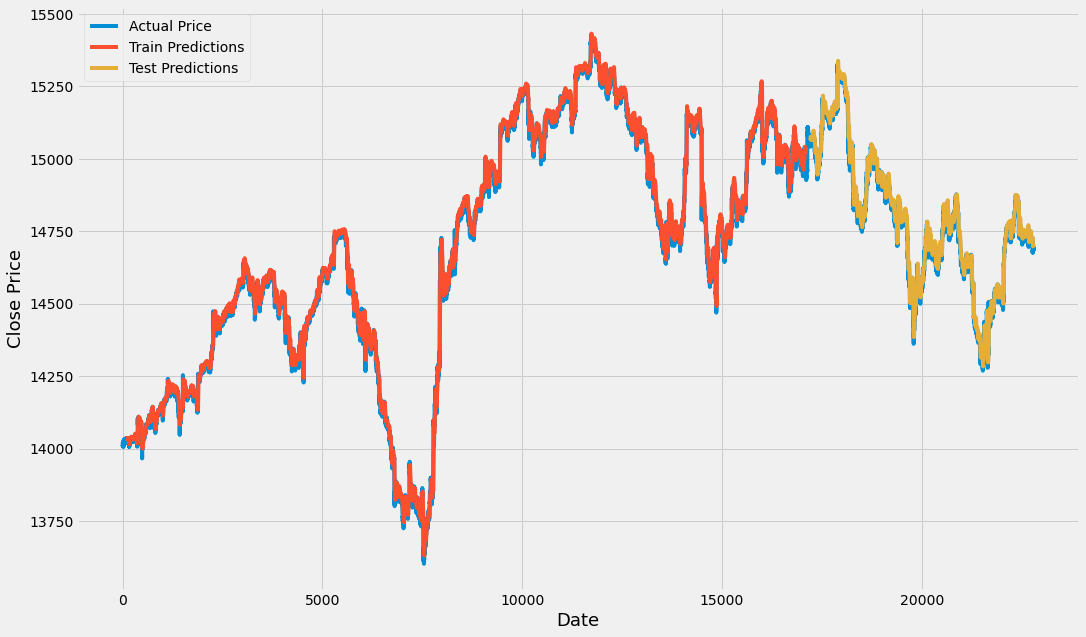

In [59]:
plt.figure(figsize=(16,10))
look_back=100
trainPredictPlot = numpy.empty_like(df5)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

testPredictPlot = numpy.empty_like(df5)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df5)-1, :] = test_predict

plt.plot(scaler.inverse_transform(df5))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price',fontsize=18)
plt.legend(['Actual Price','Train Predictions', 'Test Predictions'], loc='upper left')
plt.show()

In [60]:
len(test_data)

5702

In [61]:
x_input = test_data[5602:].reshape(1,-1)
x_input.shape

(1, 100)

In [62]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()
temp_input

[0.6098555324504762,
 0.61152457042793,
 0.6153551493925793,
 0.6164496005253355,
 0.6177903031629626,
 0.6115519317062486,
 0.6155740396191316,
 0.6164496005253355,
 0.618857393017402,
 0.6203349020466238,
 0.6189668381306763,
 0.6160118200722327,
 0.6207726824997266,
 0.6202254569333476,
 0.6164222392470169,
 0.6163401554120611,
 0.6169421035350773,
 0.6142333369815027,
 0.6220586625807147,
 0.6194046185837809,
 0.6207453212214062,
 0.6231804749917913,
 0.6214567144577003,
 0.6226332494254123,
 0.6254514610922612,
 0.6266006347816564,
 0.6231804749917913,
 0.6180639159461521,
 0.6208000437780452,
 0.6204990697165371,
 0.6162854328554221,
 0.6161212651855088,
 0.6124822151690914,
 0.6132209696837023,
 0.612919995622196,
 0.6092262230491414,
 0.6078855204115126,
 0.6083506621429358,
 0.6018934004596694,
 0.6026868775309175,
 0.6007989493269132,
 0.6048757797964317,
 0.6076939914632806,
 0.6074477399584115,
 0.6102933129035772,
 0.6101291452336657,
 0.6077213527415992,
 0.60553245047608

In [63]:
#predictions for next 10 minutes
from numpy import array
min_output=[]
n_steps=100
i=0
while(i<10):
  if(len(temp_input)>100):
    x_input=np.array(temp_input[1:])
    print("{} day input {}".format(i,x_input))
    x_input=x_input.reshape(1,-1)
    x_input=x_input.reshape((1,n_steps,1))
    yhat = model1.predict(x_input,verbose=0)
    print("{} day output {}".format(i,yhat))
    temp_input.extend(yhat[0].tolist())
    temp_input=temp_input[1:]
    min_output.extend(yhat.tolist())
    i=i+1
  else:
    x_input = x_input.reshape((1,n_steps,1))
    yhat = model1.predict(x_input,verbose=0)
    print(yhat[0])
    temp_input.extend(yhat[0].tolist())
    print(len(temp_input))
    min_output.extend(yhat.tolist())
    i=i+1

print(min_output)

[0.5993778]
101
1 day input [0.61152457 0.61535515 0.6164496  0.6177903  0.61155193 0.61557404
 0.6164496  0.61885739 0.6203349  0.61896684 0.61601182 0.62077268
 0.62022546 0.61642224 0.61634016 0.6169421  0.61423334 0.62205866
 0.61940462 0.62074532 0.62318047 0.62145671 0.62263325 0.62545146
 0.62660063 0.62318047 0.61806392 0.62080004 0.62049907 0.61628543
 0.61612127 0.61248222 0.61322097 0.61292    0.60922622 0.60788552
 0.60835066 0.6018934  0.60268688 0.60079895 0.60487578 0.60769399
 0.60744774 0.61029331 0.61012915 0.60772135 0.60553245 0.60082631
 0.60416439 0.60679107 0.60558717 0.60304257 0.60610704 0.60829594
 0.60555981 0.60676371 0.60588815 0.60454744 0.60709204 0.60843275
 0.6095272  0.61040276 0.61114151 0.60731093 0.60772135 0.61584765
 0.61311152 0.6151089  0.599212   0.58996388 0.58813068 0.59021013
 0.59089417 0.58728248 0.59601073 0.59866477 0.60148298 0.60060742
 0.59811754 0.59809018 0.59458794 0.60074423 0.59729671 0.59650323
 0.59705045 0.59527197 0.59562767 

In [64]:
min_new=np.arange(1,101)
min_pred=np.arange(101,111)

In [65]:
len(df5)

22805

In [66]:
df6=df5.tolist()
df6.extend(min_output)

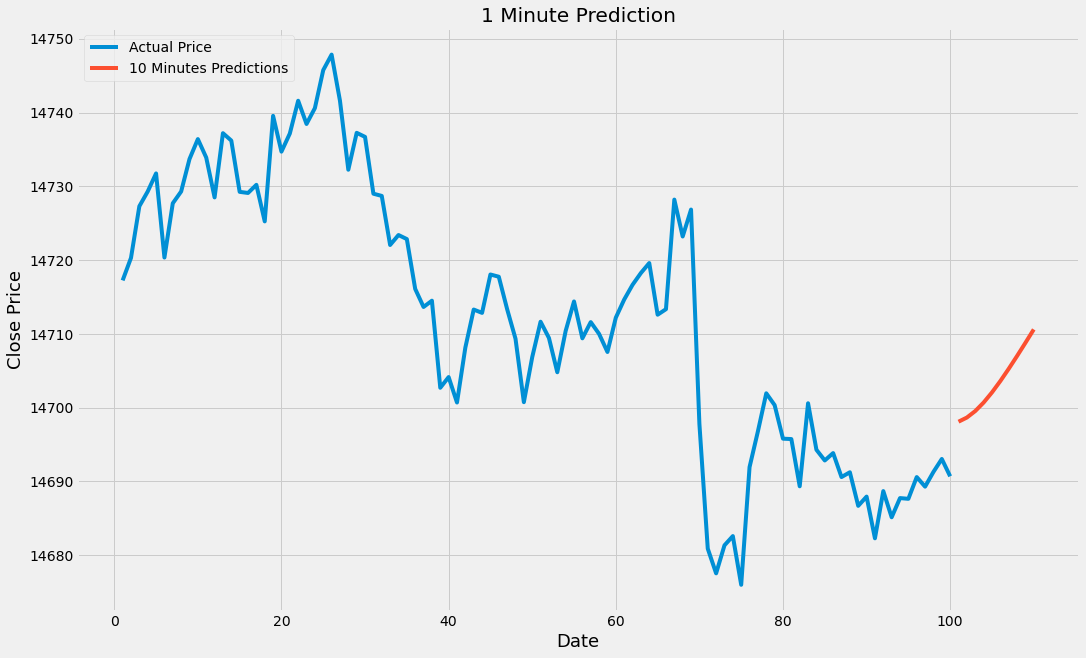

In [67]:
plt.figure(figsize=(16,10))
plt.plot(min_new,scaler.inverse_transform(df5[22705:]))
plt.plot(min_pred,scaler.inverse_transform(min_output))
plt.title('1 Minute Prediction')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price',fontsize=18)
plt.legend(['Actual Price','10 Minutes Predictions'], loc='upper left')

In [68]:
min_output

[[0.5993778109550476],
 [0.5996864438056946],
 [0.6001662611961365],
 [0.6007965207099915],
 [0.6015480160713196],
 [0.6023902297019958],
 [0.6032970547676086],
 [0.604246973991394],
 [0.6052249670028687],
 [0.6062203645706177]]